# Introduction

Recently, artificial intelligence (AI) has also been widely employed in the field of healthcare. Particularly, AI has contributed to medical diagnosis in radiology by convolutional neural network (CNN). CNN has a great capacity to classify images such as X-ray images by way of supervised learning. It is expected that AI may facilitate the quality of healthcare services and reduce workloads for healthcare professionals.

This time, a png dataset is used instead of the original RSMA dataset, because Tensorflow cannot directly read dicom file. The dataset is created by and available at [RSNA Breast Cancer Detection - 512x512 pngs](https://www.kaggle.com/datasets/theoviel/rsna-breast-cancer-512-pngs).

# Import Libraries

ResNet50 is a greatly popular and frequently used CNN model for medical AI research. The results of image classification performance by an AI model is generally estimated by classification report and confusion matrix.

In [1]:
# TensorFlow libraries
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# basic libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

import glob
from glob import glob

In [2]:
!pip install kaggle.

import zipfile
import os
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

ERROR: Invalid requirement: 'kaggle.'


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [3]:
!kaggle datasets download -d theoviel/rsna-breast-cancer-512-pngs

100% 3.50G/3.50G [03:08<00:00, 14.8MB/s]
100% 3.50G/3.50G [03:08<00:00, 19.9MB/s]


In [4]:
!mkdir Breast_cancer_Detection


In [5]:
import zipfile
import os

# Specify the path to the zip file
zip_file_path = '/content/rsna-breast-cancer-512-pngs.zip'

# Specify the target folder path
target_folder_path = '/content/Breast_cancer_Detection'

# Create the target folder if it doesn't exist
if not os.path.exists(target_folder_path):
    os.makedirs(target_folder_path)

# Extract the files from the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder_path)

print("Files extracted successfully.")


Files extracted successfully.


# Read the CSV File

Next, we get the paths to access the image data and csv data. The csv data include various information about patients, such as biopsy, malignant cancer, and invasive cancer.

In [6]:
# the path to the image data
RSNA_512_path = '/content/Breast_cancer_Detection'

In [8]:
# Read the csv data.
df_train = pd.read_csv('/content/train.csv')
df_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0.0,NaN,29.0,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0.0,NaN,29.0,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0.0,NaN,29.0,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0.0,NaN,29.0,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0.0,NaN,21.0,True


## Attention

Generally, mammography is conducted with 2 views (from 2 angles), because **the position of breast cancer is various, although the upper outer quadrant of the breast is the most common site of breast cancer occurrence**. But the shape of the breast is almost the same regardless of different views. Moreover, the left and right breast generally have the same view. Therefore, we ignore the laterality and view for the machine learning purpose. The patient of the test data has no implant, so patients having implant can be excluded from the train data set. However, this patient has no risk of false positive for cancer because of implant. Although it is unknown whether the other patients in the hidden test data set have an implant, generally few patients have implant. Thus, implant appears to have little influence on this machine learning.

In [9]:
# the number of total patients
len(df_train)

44773

In [10]:
# the number of patients having implant
len(df_train[df_train['implant'] == 1])

1206

In [11]:
# the number of patients without malignant cancer
len(df_train[df_train['cancer'] == 0])

43839

In [12]:
# the number of patient who took biopsy
len(df_train[df_train['biopsy'] == 1])

2415

In [13]:
# the number of patients having malignant cancer
len(df_train[df_train['cancer'] == 1])

934

In [14]:
# the number of patients whose malignant cancer is invasive
len(df_train[df_train['invasive'] == 1])

672

In [15]:
# the same as above
len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])

672

<Axes: xlabel='class', ylabel='count'>

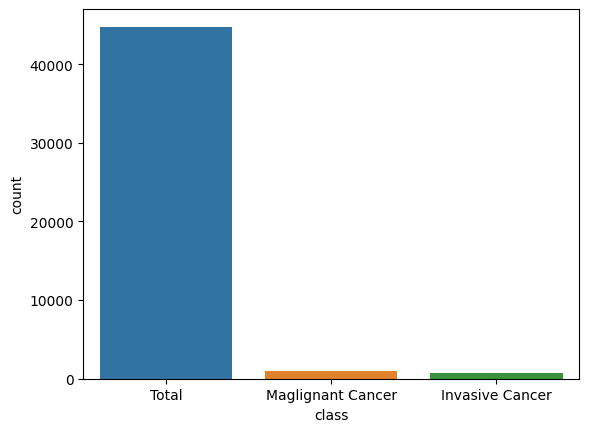

In [16]:
# Most of the cases are normal or not-malignant cancer. Thus, physicians sometimes overlook cancer.
data = pd.DataFrame(np.concatenate([['Total'] * len(df_train) , ['Maglignant Cancer'] *  len(df_train[df_train['cancer'] == 1]), ['Invasive Cancer'] *  len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

<Axes: xlabel='class', ylabel='count'>

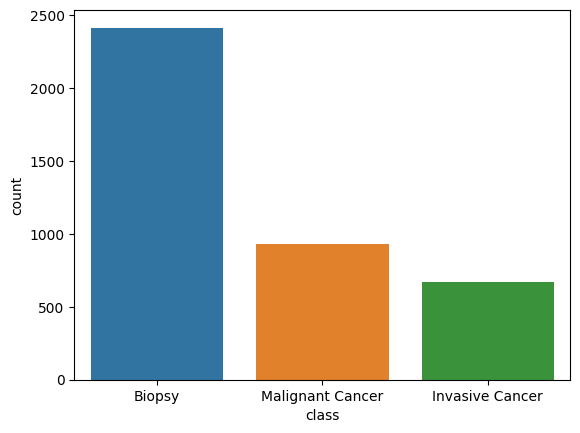

In [17]:
# Around 3000 patient took biopsy and malignant cancer was found from some of them.
data = pd.DataFrame(np.concatenate([['Biopsy'] * len(df_train[df_train['biopsy'] == 1]) , ['Malignant Cancer'] *  len(df_train[df_train['cancer'] == 1]), ['Invasive Cancer'] *  len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

In [18]:
# the number of not-malignant cancer cases from biopsy
len(df_train[(df_train['biopsy'] == 1) & (df_train['cancer'] == 0)])

1481

In [19]:
# the number of malignant cancer cases from biopsy
len(df_train[(df_train['biopsy'] == 1) & (df_train['cancer'] == 1)])

934

<Axes: xlabel='class', ylabel='count'>

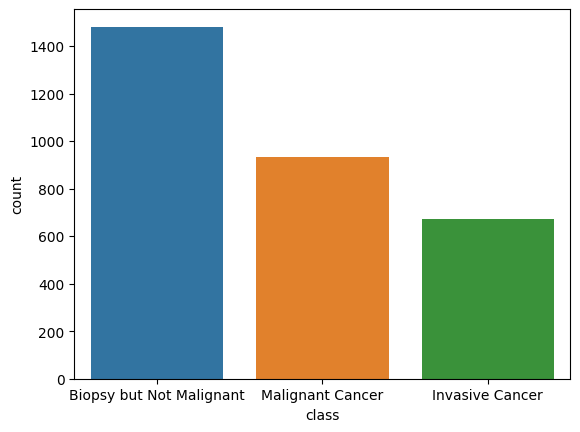

In [20]:
# 60% of biopsy resulted in not-malignanct cancer.
data = pd.DataFrame(np.concatenate([['Biopsy but Not Malignant'] * len(df_train[(df_train['biopsy'] == 1) & (df_train['cancer'] == 0)]) , ['Malignant Cancer'] *  len(df_train[df_train['cancer'] == 1]), ['Invasive Cancer'] *  len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

## Attention

This is a very difficult question whether **"not-malignant cancer" cases should be selected from (1)"the whole patients without malignant cancer," (2)"the whole patients without taking biopsy," or (3)"patients with biopsy but without malignant cancer." The first choice is optimal for initial screening for general people**, most of whom are healthy.

People generally take biopsy because not only of suspected mammography image of breast cancer, but also of their clinical findings or family history. Thus, images from **"patients with biospy but without malignant cancer" may be totally healthy or may include benign cancer or other diseases, such as inflammation**. Therefore, **the second choice may be optimal, if the initial screening is only conducted for detection of malignant breast cancer**, and the patients do not suffer from any other diseases.

**The third choice is optimal** for special screening for suspected cases of malignanct cancer. This is particularly useful **when it is supected that a patient might suffer malignant cancer**. This AI would be used before biopsy is conducted.

In this competition, the purpose of screening is not suffiently clear, because the test data do not inlude information as to biopsy. This time we take the third choice, but another choice might be better for the purpose of the competition.

In [21]:
# The not-malignant cancer cases were limited into biopsy cases.
DF_train = df_train[df_train['biopsy'] == 1].reset_index(drop = True)
DF_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,1,10102,453020471,R,CC,40.0,0,1,0,0.0,0.0,B,49.0,True
1,1,10102,1181635673,R,MLO,40.0,0,1,0,0.0,0.0,B,49.0,True
2,1,10102,1241778584,R,MLO,40.0,0,1,0,0.0,0.0,B,49.0,True
3,1,10102,1951607544,R,CC,40.0,0,1,0,0.0,0.0,B,49.0,True
4,1,10130,388811999,L,MLO,71.0,1,1,1,0.0,0.0,B,49.0,False


In [22]:
# The number of positive (malignant) and negative (not-malignat) cases should be the same
# to create a balanced dataset.
DF_train = DF_train.groupby(['cancer']).apply(lambda x: x.sample(1158, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', DF_train.shape[0])

New Data Size: 2316


<Axes: xlabel='class', ylabel='count'>

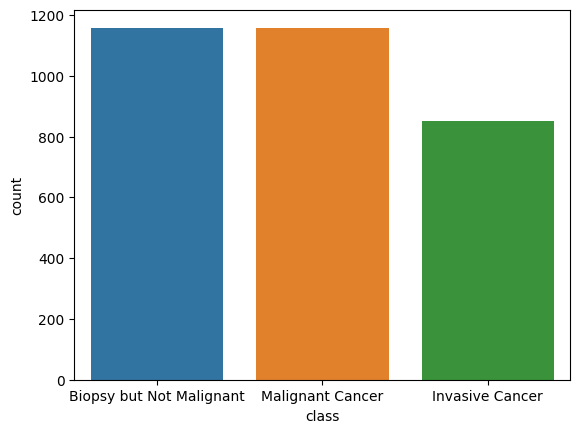

In [23]:
# Generally, invasive cancer is confirmed by biopsy, not by mammography.
# Maybe it is also extremely difficult for AI to detect invasive cancer from mammography.
data = pd.DataFrame(np.concatenate([['Biopsy but Not Malignant'] * len(DF_train[(DF_train['biopsy'] == 1) & (DF_train['cancer'] == 0)]) , ['Malignant Cancer'] *  len(DF_train[DF_train['cancer'] == 1]), ['Invasive Cancer'] *  len(DF_train[(DF_train['cancer'] == 1) & (DF_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

# Create the Path to Each Image

In [24]:
# Create the path to each image.
for i in range(len(DF_train)):
    DF_train.loc[i, 'path'] = os.path.join(RSNA_512_path + '/' + str(DF_train.loc[i, 'patient_id']) + '_' + str(DF_train.loc[i, 'image_id']) + '.png')
DF_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,1,36971,1101458088,R,MLO,35.0,0,1,0,0.0,0.0,C,49.0,True,/content/Breast_cancer_Detection/36971_1101458...
1,1,21180,2005051070,L,MLO,40.0,0,1,0,0.0,0.0,B,49.0,True,/content/Breast_cancer_Detection/21180_2005051...
2,1,36680,572988849,R,MLO,51.0,0,1,0,0.0,0.0,C,49.0,True,/content/Breast_cancer_Detection/36680_5729888...
3,1,56621,1040727936,R,MLO,41.0,0,1,0,0.0,0.0,D,49.0,True,/content/Breast_cancer_Detection/56621_1040727...
4,1,48190,719727474,L,MLO,49.0,0,1,0,0.0,0.0,C,49.0,True,/content/Breast_cancer_Detection/48190_7197274...


In [25]:
# a sample path
DF_train.loc[0, 'path']

'/content/Breast_cancer_Detection/36971_1101458088.png'

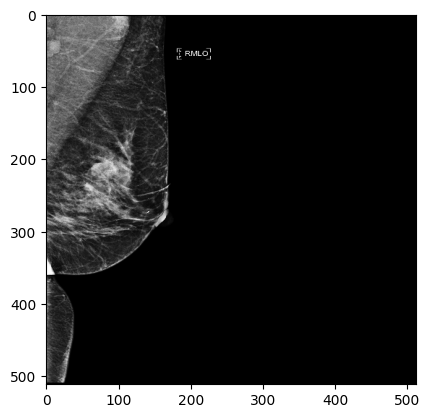

In [26]:
# a sample image
img = cv2.imread(DF_train.loc[0, 'path'])
plt.imshow(img, cmap = 'gray')

In [27]:
img

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[124, 124, 124],
        [138, 138, 138],
        [146, 146, 146],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[ 99,  99,  99],
        [ 94,  94,  94],
        [ 72,  72,  72],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [28]:
img.shape

(512, 512, 3)

# Divide the Data into Training and Validation

This time we devide the data into training and validation data, because test data originally exist.

In [29]:
# Normal and cancer images must be equally distrubuted.
train_df, val_df = train_test_split(DF_train,
                                   test_size = 0.10,
                                   random_state = 2018,
                                   stratify = DF_train[['cancer']])

print('train', train_df.shape[0], 'validation', val_df.shape[0])
print('train', train_df['cancer'].value_counts())
print('validation', val_df['cancer'].value_counts())
train_df.sample(1)

train 2084 validation 232
train 1    1042
0    1042
Name: cancer, dtype: int64
validation 0    116
1    116
Name: cancer, dtype: int64


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
1220,2,31964,488598184,L,CC,50.0,1,1,1,NaN,0.0,NaN,48.0,False,/content/Breast_cancer_Detection/31964_4885981...


In [30]:
# training data
train_df.head(5)

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
1311,1,30435,63956271,R,CC,75.0,1,1,1,0.0,0.0,A,49.0,False,/content/Breast_cancer_Detection/30435_6395627...
673,1,4748,1554066784,R,MLO,48.0,0,1,0,0.0,0.0,C,49.0,True,/content/Breast_cancer_Detection/4748_15540667...
145,1,2028,2077153957,L,MLO,81.0,0,1,0,0.0,0.0,A,49.0,True,/content/Breast_cancer_Detection/2028_20771539...
814,1,46999,571528877,L,MLO,51.0,0,1,0,0.0,0.0,B,49.0,True,/content/Breast_cancer_Detection/46999_5715288...
862,1,54291,480335888,R,MLO,69.0,0,1,0,0.0,0.0,A,49.0,True,/content/Breast_cancer_Detection/54291_4803358...


In [31]:
# validation data
val_df.head(5)

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
117,2,12203,1495668425,L,MLO,60.0,0,1,0,NaN,0.0,NaN,48.0,True,/content/Breast_cancer_Detection/12203_1495668...
1342,2,16346,1171817874,R,CC,62.0,1,1,0,NaN,0.0,NaN,29.0,False,/content/Breast_cancer_Detection/16346_1171817...
1963,2,16518,442815464,L,MLO,51.0,1,1,1,NaN,0.0,NaN,48.0,False,/content/Breast_cancer_Detection/16518_4428154...
300,2,17891,1600889469,R,CC,49.0,0,1,0,NaN,0.0,NaN,29.0,True,/content/Breast_cancer_Detection/17891_1600889...
879,1,38750,1466657813,R,MLO,60.0,0,1,0,0.0,0.0,B,49.0,True,/content/Breast_cancer_Detection/38750_1466657...


In [32]:
# Pick up normal images from the training data.
train_df_normal = train_df[train_df['cancer'] == 0].reset_index(drop = True)
print(len(train_df_normal))
train_df_normal.head(5)

1042


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,1,4748,1554066784,R,MLO,48.0,0,1,0,0.0,0.0,C,49.0,True,/content/Breast_cancer_Detection/4748_15540667...
1,1,2028,2077153957,L,MLO,81.0,0,1,0,0.0,0.0,A,49.0,True,/content/Breast_cancer_Detection/2028_20771539...
2,1,46999,571528877,L,MLO,51.0,0,1,0,0.0,0.0,B,49.0,True,/content/Breast_cancer_Detection/46999_5715288...
3,1,54291,480335888,R,MLO,69.0,0,1,0,0.0,0.0,A,49.0,True,/content/Breast_cancer_Detection/54291_4803358...
4,1,2083,331933117,R,MLO,41.0,0,1,0,0.0,0.0,B,49.0,True,/content/Breast_cancer_Detection/2083_33193311...


In [33]:
# Pick up cancer images from the training data.
train_df_cancer = train_df[train_df['cancer'] == 1].reset_index(drop = True)
print(len(train_df_cancer))
train_df_cancer.head(5)

1042


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,1,30435,63956271,R,CC,75.0,1,1,1,0.0,0.0,A,49.0,False,/content/Breast_cancer_Detection/30435_6395627...
1,1,3542,593840512,R,CC,68.0,1,1,1,0.0,0.0,A,190.0,False,/content/Breast_cancer_Detection/3542_59384051...
2,2,4888,1705616801,L,MLO,54.0,1,1,1,NaN,0.0,NaN,48.0,False,/content/Breast_cancer_Detection/4888_17056168...
3,2,21888,1472830410,R,MLO,70.0,1,1,1,NaN,0.0,NaN,21.0,False,/content/Breast_cancer_Detection/21888_1472830...
4,1,47055,102668587,L,CC,76.0,1,1,1,0.0,0.0,C,49.0,False,/content/Breast_cancer_Detection/47055_1026685...


In [34]:
# Pick up normal images from the validation data.
val_df_normal = val_df[val_df['cancer'] == 0].reset_index(drop = True)
print(len(val_df_normal))
val_df_normal.head(5)

116


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,12203,1495668425,L,MLO,60.0,0,1,0,NaN,0.0,NaN,48.0,True,/content/Breast_cancer_Detection/12203_1495668...
1,2,17891,1600889469,R,CC,49.0,0,1,0,NaN,0.0,NaN,29.0,True,/content/Breast_cancer_Detection/17891_1600889...
2,1,38750,1466657813,R,MLO,60.0,0,1,0,0.0,0.0,B,49.0,True,/content/Breast_cancer_Detection/38750_1466657...
3,1,24566,182623219,R,CC,56.0,0,1,0,0.0,0.0,C,49.0,True,/content/Breast_cancer_Detection/24566_1826232...
4,1,36894,105222190,R,CC,74.0,0,1,0,0.0,1.0,D,49.0,True,/content/Breast_cancer_Detection/36894_1052221...


In [35]:
# Pick up cancer images from the validation data.
val_df_cancer = val_df[val_df['cancer'] == 1].reset_index(drop = True)
print(len(val_df_cancer))
val_df_cancer.head(5)

116


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,16346,1171817874,R,CC,62.0,1,1,0,NaN,0.0,NaN,29.0,False,/content/Breast_cancer_Detection/16346_1171817...
1,2,16518,442815464,L,MLO,51.0,1,1,1,NaN,0.0,NaN,48.0,False,/content/Breast_cancer_Detection/16518_4428154...
2,2,15696,1147761893,L,CC,65.0,1,1,1,NaN,0.0,NaN,48.0,False,/content/Breast_cancer_Detection/15696_1147761...
3,1,22562,1512279672,R,CC,78.0,1,1,0,0.0,0.0,C,170.0,False,/content/Breast_cancer_Detection/22562_1512279...
4,1,25909,1201889471,R,CC,43.0,1,1,0,0.0,0.0,C,49.0,False,/content/Breast_cancer_Detection/25909_1201889...


**We have to store the 4 datasets in each folder to be used for machine learing of TensorFlow AI model.**

In [36]:
import shutil
# Define the destination directory.
destination_dir = '/content/data_preparation/train'
destination_dir_sub = '/content/data_preparation/train/normal'

# Create the destination directory if it doesn't exist.
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)

# Copy the images to the destination directory.
for path in train_df_normal['path']:
    shutil.copy2(path, destination_dir_sub)

In [37]:
# Define the destination directory.
destination_dir = '/content/data_preparation/train'
destination_dir_sub = '/content/data_preparation/train/cancer'

# Create the destination directory if it doesn't exist.
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)

# Copy the images to the destination directory.
for path in train_df_cancer['path']:
    shutil.copy2(path, destination_dir_sub)

In [38]:
# Define the destination directory.
destination_dir = '/content/data_preparation/val'
destination_dir_sub = '/content/data_preparation/val/normal'

# Create the destination directory if it doesn't exist.
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)

# Copy the images to the destination directory.
for path in val_df_normal['path']:
    shutil.copy2(path, destination_dir_sub)

In [39]:
# Define the destination directory.
destination_dir = '/content/data_preparation/val'
destination_dir_sub = '/content/data_preparation/val/cancer'

# Create the destination directory if it doesn't exist.
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)

# Copy the images to the destination directory.
for path in val_df_cancer['path']:
    shutil.copy2(path, destination_dir_sub)

# Sample Images

In [40]:
import glob
normal_train_images = glob.glob('/content/data_preparation/train/normal/*.png')
cancer_train_images = glob.glob('/content/data_preparation/train/cancer/*.png')

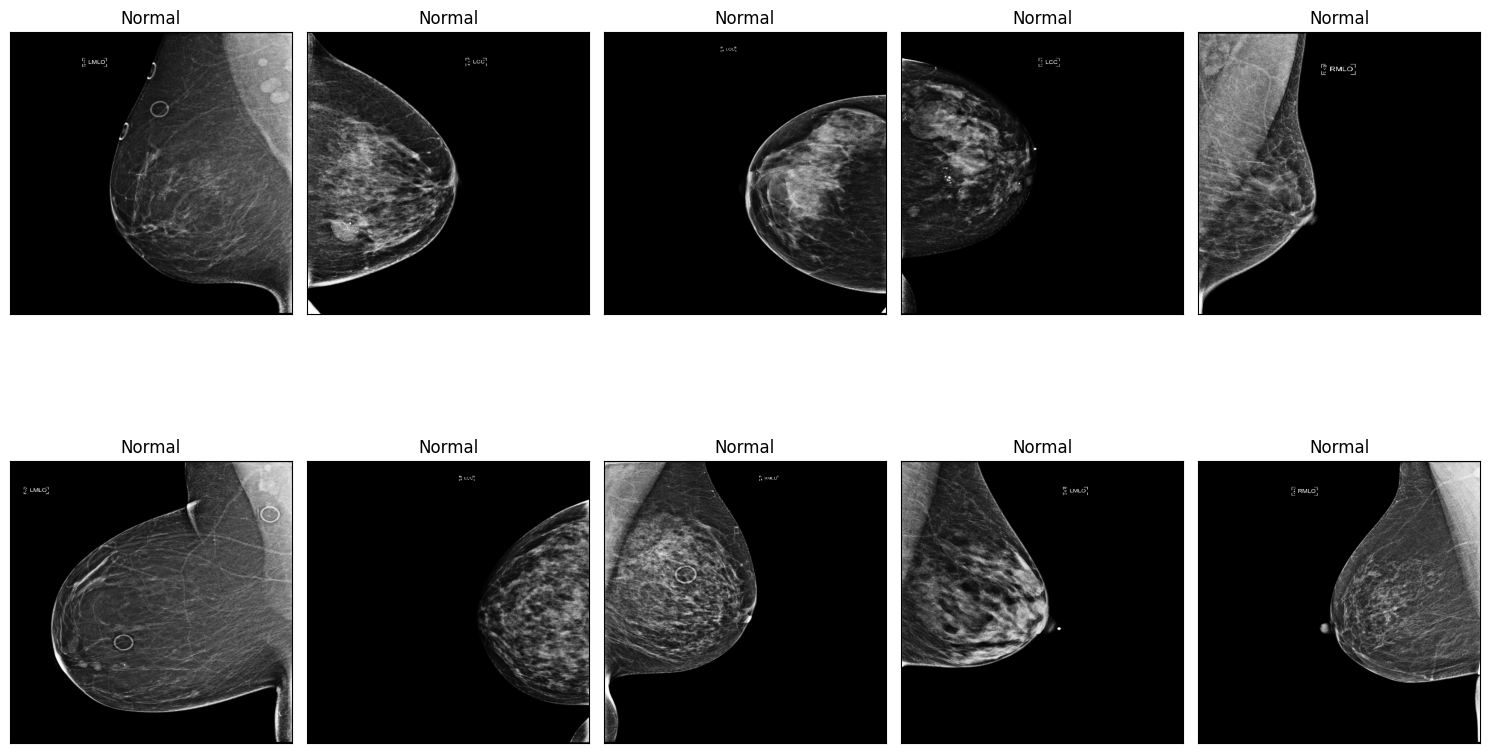

In [41]:
# See normal images from the training dataset.
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_train_images[i])
    ax.imshow(img)
    ax.set_title('Normal')
fig.tight_layout()

plt.show()

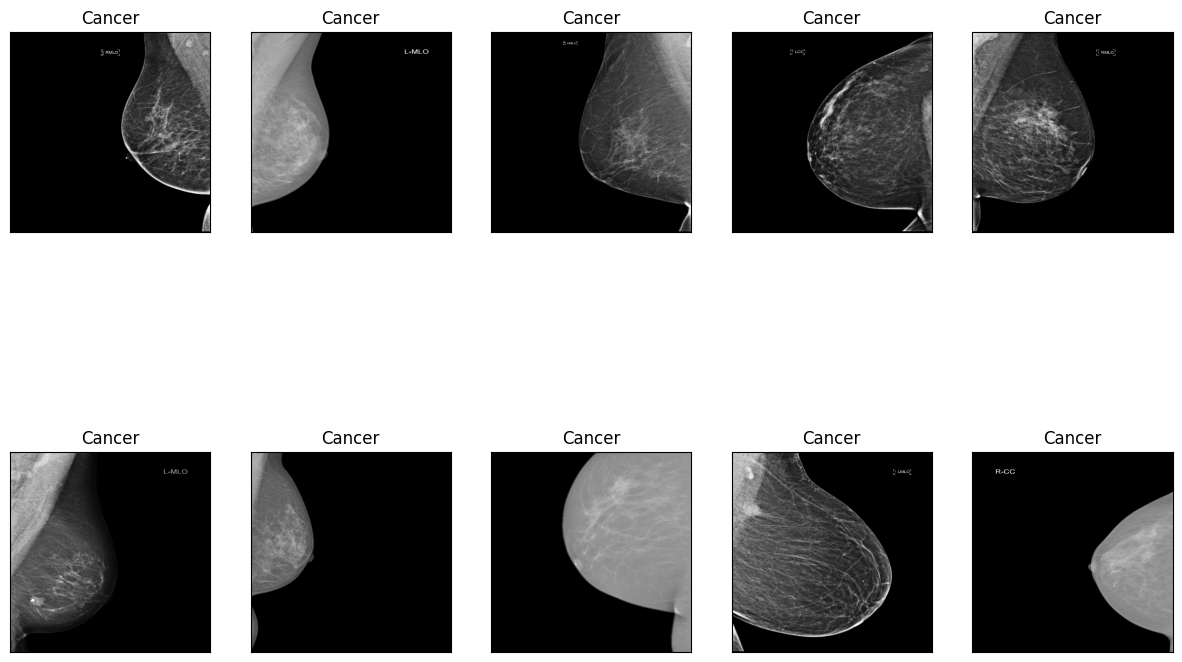

In [42]:
# See cancer images from the training dataset.
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(cancer_train_images[i])
    ax.imshow(img)
    ax.set_title('Cancer')

plt.show()

# Create Image data Generators

The dataset has already been divided into train and validation datasets, and each dataset includes normal and cancer image files. Thus, image data generators were easily created.

In [43]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   zoom_range = 0.2)
val_datagen = ImageDataGenerator(rescale = 1./255.,)

In [44]:
train_path = '/content/data_preparation/train'
val_path = '/content/data_preparation/val'

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (512, 512),
    batch_size = 32,
    class_mode = 'binary'
)
validation_generator = val_datagen.flow_from_directory(
        val_path,
        target_size = (512, 512),
        batch_size = 16,
        class_mode = 'binary'
)

Found 1362 images belonging to 2 classes.
Found 217 images belonging to 2 classes.


# Define the Model (Transfer Learning)

Here, ResNet50V2 was employed as the base model for transfer learning. It would be also possible to conduct fine tuning with the model. The choice of hyperparameters depends on the type of task by machine learning. Sigmoid, adam, and binary cross entropy were selected for the final activation function, optimizer, and loss function, respectively.

In [45]:
base_model = ResNet50V2(weights = 'imagenet', input_shape = (512, 512, 3), include_top = False)

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))



94668760/94668760 [==============================] - 5s 0us/step


In [46]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Defining early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Model Checkpoint to save the best model weights
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [47]:
# model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ["accuracy"])

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 16, 16, 2048)      23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

# Train the Model

The model was trained with the train and validation data. Early stopping was added to prevent overfitting. In fact, it might be preferable to set the larger number of epochs.

In [49]:
!pip install memory_profiler

In [50]:
# Training the model with attention mechanism and transfer learning
import time
import memory_profiler
start_time = time.time()
history=model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 20,epochs=200,callbacks=[early_stopping, model_checkpoint, reduce_lr])
end_time = time.time()

memory_used = memory_profiler.memory_usage()

print(f"Time complexity: {end_time - start_time}")
print(f"Memory used: {memory_used}")

Epoch 1/200
20/20 [==============================] - ETA: 0s - loss: 0.6691 - accuracy: 0.5953
Epoch 1: val_loss improved from inf to 0.66832, saving model to best_model.h5
20/20 [==============================] - 48s 2s/step - loss: 0.6691 - accuracy: 0.5953 - val_loss: 0.6683 - val_accuracy: 0.5622 - lr: 0.0010
Epoch 2/200
20/20 [==============================] - ETA: 0s - loss: 0.6452 - accuracy: 0.6246
Epoch 2: val_loss did not improve from 0.66832
20/20 [==============================] - 33s 2s/step - loss: 0.6452 - accuracy: 0.6246 - val_loss: 0.6845 - val_accuracy: 0.5161 - lr: 0.0010
Epoch 3/200
20/20 [==============================] - ETA: 0s - loss: 0.6438 - accuracy: 0.6234
Epoch 3: val_loss did not improve from 0.66832
20/20 [==============================] - 34s 2s/step - loss: 0.6438 - accuracy: 0.6234 - val_loss: 0.7069 - val_accuracy: 0.5945 - lr: 0.0010
Epoch 4/200
20/20 [==============================] - ETA: 0s - loss: 0.6271 - accuracy: 0.6484
Epoch 4: val_loss did 

# Save the Model

In [51]:
model.save('mammography_pred_model.h5')

# Model Metrics

The accuracy and loss were calculated for both train and validation data in the model training process.

In [52]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Visualizing Accuracy and Loss

Text(0, 0.5, 'loss')

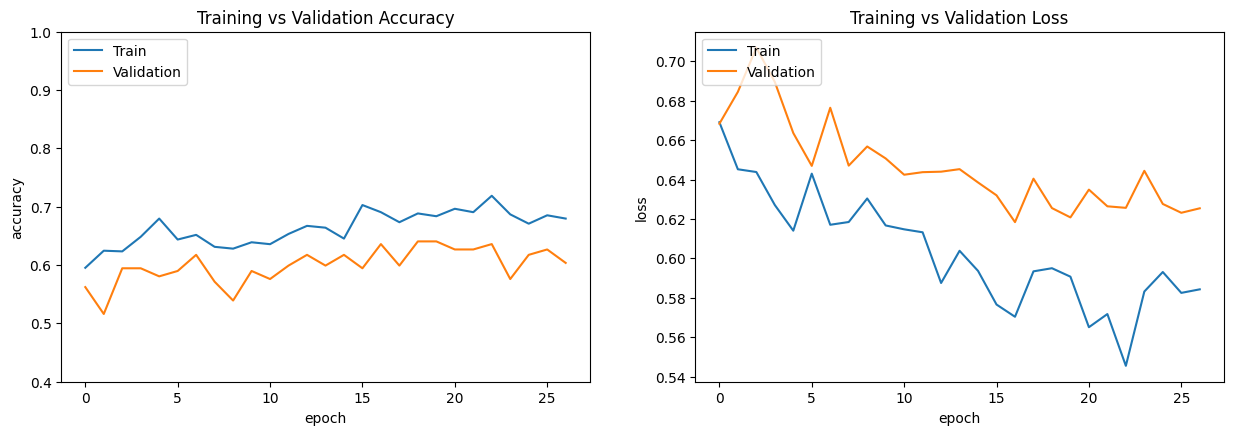

In [53]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

# Predictions

In order to evaluate the quality of the trained model, the outcome was predicted from the test (validation) data and compared with the observed value. **The threshold was set as 0.5 and the predicted value of more than 0.5 was treated as 1, which is positive.**

In [54]:
from tensorflow.keras.models import load_model
model = load_model('/content/mammography_pred_model.h5')

In [55]:
pred = model.predict(validation_generator)

14/14 [==============================] - 2s 116ms/step


In [56]:
# prediction by the AI
pred

array([[0.52130353],
       [0.30448142],
       [0.7199549 ],
       [0.62055933],
       [0.48027456],
       [0.373784  ],
       [0.29648668],
       [0.6530666 ],
       [0.4414026 ],
       [0.5697576 ],
       [0.6111516 ],
       [0.665302  ],
       [0.83938056],
       [0.8436412 ],
       [0.49102268],
       [0.530675  ],
       [0.52874583],
       [0.7015978 ],
       [0.5634036 ],
       [0.39988345],
       [0.4826006 ],
       [0.5566648 ],
       [0.39868504],
       [0.41057768],
       [0.15543616],
       [0.5477614 ],
       [0.5319395 ],
       [0.5899449 ],
       [0.5545161 ],
       [0.45928624],
       [0.5385348 ],
       [0.471323  ],
       [0.2661484 ],
       [0.58869314],
       [0.5411704 ],
       [0.4211819 ],
       [0.72133845],
       [0.7378324 ],
       [0.395035  ],
       [0.50307363],
       [0.53954756],
       [0.7202741 ],
       [0.5812156 ],
       [0.8530826 ],
       [0.47269297],
       [0.45671508],
       [0.888298  ],
       [0.528

In [57]:
y_pred = []
for prob in pred:
    if prob >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [58]:
print(y_pred)

[1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0]


In [59]:
pd.Series(y_pred).value_counts()

1    116
0    101
dtype: int64

In [60]:
y_true = validation_generator.classes

In [61]:
print(y_true)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
